# LeNet-5

Perhaps the first widely known and successful application of convolutional neural networks was **LeNet-5**, described by Yann LeCun, et al. in their 1998 paper titled [Gradient-Based Learning Applied to Document Recognition](https://ieeexplore.ieee.org/document/726791). The system was developed for use in a handwritten character recognition problem and demonstrated on the **MNIST standard dataset**, achieving approximately 99.2% classification accuracy (or a 0.8% error rate). The network was then described as the central technique in a broader system referred to as **Graph Transformer Networks**.

It is a long paper, and perhaps the best part to focus on is Section II. B. that describes the LeNet-5 architecture. In that section, the paper describes the **network as having seven layers** with input **grayscale images** having the shape **32 x 32**, the size of images in the **MNIST dataset**. 

> The model proposes a pattern of a convolutional layer followed by an average pooling layer, referred to as a **subsampling layer**. 

This pattern is repeated two and a half times before the output feature maps are flattened and fed to some fully connected layers for interpretation and a final prediction. A picture of the network architecture is provided in the paper and reproduced below.

<img width="800" src="https://drive.google.com/uc?export=view&id=1nqbLzHfqorX80I8upHMWINwPNfrmLW-V"/>

The pattern of blocks of convolutional layers and pooling layers (referred to as **subsampling**) grouped and repeated **remains a typical pattern in designing and using convolutional neural networks today, more than twenty years later**. Interestingly, the architecture uses a small number of filters with a modest size as the first hidden layer, specifically 6 filters, each with 5x5 pixels. After pooling, another convolutional layer has many more filters, again with the same size, precisely 16 filters with 5x5 pixels, again followed by pooling. In the repetition of these two blocks of convolution and pooling layers, the trend increases the number of filters.

Compared to modern applications, the number of filters is also small, but **the trend of increasing the number of filters with the depth of the network also remains a common pattern in modern usage of the technique.** The flattening of the feature maps and interpretation and classification of the extracted features by fully connected layers also remains a common pattern today. 

> In modern terminology, the **final section of the architecture** is often referred to as the **classifier**, whereas the **convolutional and pooling layers** earlier in the model are referred to as the **feature extractor**.

We can summarize the key aspects of the architecture relevant in modern models as follows:

- Fixed-sized input images.
- Group convolutional and pooling layers into blocks.
- Repetition of convolutional-pooling blocks in the architecture.
- Increase in the number of filters with the depth of the network.
- Distinct feature extraction and classifier parts of the architecture.

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 15.8 MB/s 
     |████████████████████████████████| 166 kB 51.2 MB/s 
     |████████████████████████████████| 182 kB 70.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 166 kB 69.8 MB/s 
     |████████████████████████████████| 162 kB 74.2 MB/s 
     |████████████████████████████████| 162 kB 72.2 MB/s 
     |████████████████████████████████| 158 kB 72.7 MB/s 
     |████████████████████████████████| 157 kB 72.1 MB/s 
     |████████████████████████████████| 157 kB 73.5 MB/s 
     |████████████████████████████████| 157 kB 71.1 MB/s 
     |████████████████████████████████| 157 kB 71.4 MB/s 
     |████████████████████████████████| 157 kB 76.0 MB/s 
     |████████████████████████████████| 157 kB 73.2 MB/s 
     |████████████████████████████████| 157 kB 72.7 MB/s 
     |████████████████████████████████| 156 kB 67.7 MB/s 


In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 15.2 MB/s 
     |████████████████████████████████| 99 kB 9.7 MB/s 
     |████████████████████████████████| 66 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=6b811643fd95704a235fc34be89440ce6412f62882bf0836efb50b075035a82e
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


### Import Packages

In [3]:
# import the necessary packages
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02: Implementing LeNet-5


<img width="800" src="https://drive.google.com/uc?export=view&id=1RF_HWPSImajab-i1ayFeEOoFON0Ky-28"/>

Source code based on **Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019** [link](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [ ]:
class LeNet:

  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation='tanh', input_shape=(28,28,1), )) #C1
    model.add(AveragePooling2D()) #S2

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='tanh')) #C3
    model.add(AveragePooling2D()) #S4

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) #C5
    model.add(Dense(84, activation='tanh')) #F6

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [ ]:
# create a model object
model = LeNet.build(28,28,1,10)

# summarize layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

## Step 03: LeNet-5 on MNIST

### Fetch, Preprocessing and Data Segregation

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "lenet-5"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="marianabritoazevedo",
                 project=args["project_name"], 
                 job_type="Train")

In [ ]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

19-10-2022 15:43:24 [INFO] accessing MNIST...
19-10-2022 15:43:24 Train x: (60000, 28, 28)
19-10-2022 15:43:24 Train y: (60000,)
19-10-2022 15:43:24 Test x: (10000, 28, 28)
19-10-2022 15:43:24 Test y: (10000,)


In [ ]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

19-10-2022 15:43:36 Train x: (60000, 28, 28, 1)
19-10-2022 15:43:36 Train y: (60000,)
19-10-2022 15:43:36 Test x: (10000, 28, 28, 1)
19-10-2022 15:43:36 Test y: (10000,)


In [ ]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training

In [ ]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = Adam(learning_rate=0.01)
model = LeNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the network
logger.info("[INFO] training network...")
history = model.fit(train_x, train_y,
              validation_data=(test_x, test_y),
              batch_size=32,
              epochs=20, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)])

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

19-10-2022 15:43:43 [INFO] compiling model...
19-10-2022 15:43:43 [INFO] training network...
19-10-2022 15:43:43 From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_ops.py:5219: tensor_shape_from_node_def_name (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


### Evaluation Metrics

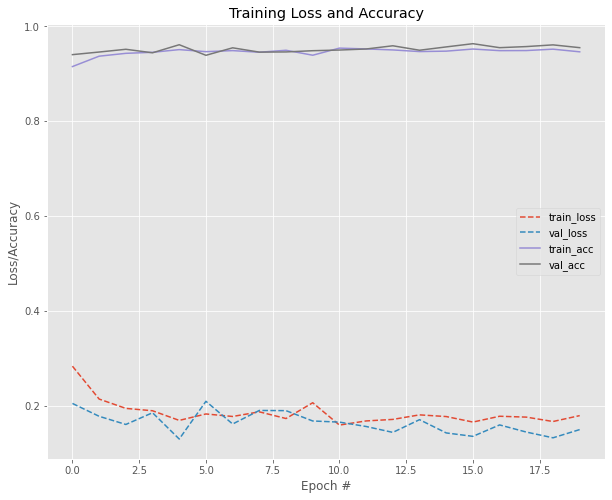

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.003083372135445367 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0001887131061705854 kWh
[INFO] Energy consumed for all GPU: 0.0012070965134398145 kWh
[INFO] Energy consumed for all CPU: 0.0016875625158349675 kWh
[INFO] CO2 emission 0.0008803142711298149(in Kg)


In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.97      0.96      0.97      1032
           3       0.91      0.97      0.94      1010
           4       0.95      0.95      0.95       982
           5       0.97      0.93      0.95       892
           6       0.97      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.90      0.93       974
           9       0.92      0.94      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000



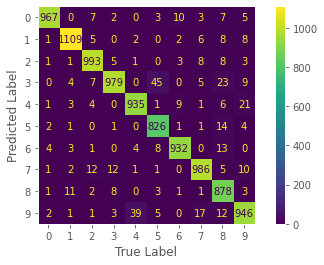

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

19-10-2022 15:46:27 Uploading figures


In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

19-10-2022 15:46:28 Validation Evaluation metrics
19-10-2022 15:46:28 Validation Accuracy: 0.9551
19-10-2022 15:46:28 Validation Precision: 0.9555404498493528
19-10-2022 15:46:28 Validation Recall: 0.9551
19-10-2022 15:46:28 Validation F1: 0.9550502545943944


In [ ]:
run.finish()

accuracy,▁▅▆▆▇▇▇▆▇▅██▇▇▇█▇▇█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▂▂▃▂▄▁▁▂▂▂▁▂▂▁▂
val_accuracy,▁▃▅▃▇▁▆▃▃▄▄▅▇▄▆█▆▆▇▆
val_loss,█▅▄▆▁█▄▆▆▄▄▃▂▅▂▁▄▂▁▃
Acc,0.9551
CO2_Emissions,0.00088
Count_Params,61706
Energy_CPU,0.00169
Energy_Consumed,0.00308
Energy_GPU,0.00121


## Step 4 - Hyperparameter tuning in Lenet-5

### Configuring sweep

In [ ]:
# Configure the sweep 
sweep_config = {
    'method': 'random', 
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'conv_layer': {
            'max': 4,
            'min': 2,
            'distribution': 'int_uniform',
        },
        'pooling': {
            #'values': [MaxPooling2D(), AveragePooling2D()], 
            'values': [0, 1], 
        },
        'qtd_filters': {
            'values': [4, 8, 16, 32]
        },
        'filter_size': {
            'values': [2, 3, 4, 5]  
        },
        'learn_rate': {
            'values': [0.01,0.001],  
        },
        'epoch': {
            'values': [20,40]
        },
        'batch_size': {
            'values': [32,64]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity="marianabritoazevedo", project=args["project_name"])

Create sweep with ID: z4sug7m0
Sweep URL: https://wandb.ai/marianabritoazevedo/lenet-5/sweeps/z4sug7m0


### Adapting the model

In [ ]:
class LeNetAdapt:

  @staticmethod
  def build(width, height, depth, classes, config):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    for i in range(config.conv_layer):
      model.add(Conv2D(config.qtd_filters, (config.filter_size, config.filter_size), strides=1, padding='same',
                      activation='tanh', input_shape=(28,28,1), )) #C1
      if config.pooling == 0:
        model.add(MaxPooling2D()) 
      else:
        model.add(AveragePooling2D()) 

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) #C5
    model.add(Dense(84, activation='tanh')) #F6

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

### Training

In [ ]:
def train():
    with wandb.init() as run:

      # create codecarbon tracker
      # codecarbon is too much verbose, change the log level for more info
      tracker = EmissionsTracker(log_level="critical")
      tracker.start()

      # initialize the optimizer and model
      print("[INFO] compiling model...")
      opt = SGD(learning_rate=run.config.learn_rate)
      model = LeNetAdapt.build(width=28, 
                               height=28,
                               depth=1, 
                               classes=10,
                               config=run.config)
      model.compile(loss="categorical_crossentropy", 
                    optimizer=opt,metrics=["accuracy"])

      # train the network
      print("[INFO] training network...")
      history = model.fit(train_x, train_y, 
                    validation_data=(test_x, test_y),
                    batch_size=run.config.batch_size, 
                    epochs=run.config.epoch, 
                    verbose=0,
                    callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                        compute_flops=True)]
                )

      # get co2 emissions from tracker
      # "CO2 emission (in Kg)"
      emissions = tracker.stop()

      # make predictions
      predictions = model.predict(test_x, batch_size=run.config.batch_size)

      # Evaluation Metrics
      logger.info("Validation Evaluation metrics")
      fbeta = fbeta_score(test_y.argmax(axis=1), 
                          predictions.argmax(axis=1), 
                          beta=1, zero_division=1,average='weighted')
      precision = precision_score(test_y.argmax(axis=1),
                                  predictions.argmax(axis=1),
                                  zero_division=1,average='weighted')
      recall = recall_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
      acc = accuracy_score(test_y.argmax(axis=1),
                          predictions.argmax(axis=1))

      logger.info("Validation Accuracy: {}".format(acc))
      logger.info("Validation Precision: {}".format(precision))
      logger.info("Validation Recall: {}".format(recall))
      logger.info("Validation F1: {}".format(fbeta))

      run.summary["Acc"] = acc
      run.summary["Precision"] = precision
      run.summary["Recall"] = recall
      run.summary["F1"] = fbeta
      # number of parameters
      run.summary["Count_Params"] = model.count_params()
      # energy unit is kWh
      run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
      run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
      run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
      run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
      # kg
      run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

In [ ]:
wandb.agent(sweep_id = sweep_id, function=train, count=10)

wandb: Agent Starting Run: kgmvbof1 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 4
wandb: 	epoch: 40
wandb: 	filter_size: 2
wandb: 	learn_rate: 0.001
wandb: 	pooling: 0
wandb: 	qtd_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


19-10-2022 15:50:22 Validation Evaluation metrics
19-10-2022 15:50:22 Validation Accuracy: 0.9119
19-10-2022 15:50:22 Validation Precision: 0.9122540186005755
19-10-2022 15:50:22 Validation Recall: 0.9119
19-10-2022 15:50:22 Validation F1: 0.9118977677857975


accuracy,▁▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,████▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████████████
val_loss,████▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.9119
CO2_Emissions,0.00129
Count_Params,16254
Energy_CPU,0.0024
Energy_Consumed,0.00452
Energy_GPU,0.00185


wandb: Agent Starting Run: ezbpah6p with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 4
wandb: 	epoch: 40
wandb: 	filter_size: 5
wandb: 	learn_rate: 0.001
wandb: 	pooling: 0
wandb: 	qtd_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


19-10-2022 15:54:49 Validation Evaluation metrics
19-10-2022 15:54:49 Validation Accuracy: 0.9481
19-10-2022 15:54:49 Validation Precision: 0.9481007926333241
19-10-2022 15:54:49 Validation Recall: 0.9481
19-10-2022 15:54:49 Validation F1: 0.948032262456036


accuracy,▁▁▁▁▂▂▂▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇██████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███████▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▂▂▂▂▃▄▅▅▆▆▆▇▇▇▇▇▇███████████████████
val_loss,██████▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.9481
CO2_Emissions,0.00161
Count_Params,12930
Energy_CPU,0.00297
Energy_Consumed,0.00564
Energy_GPU,0.00234


wandb: Agent Starting Run: k0a8k2jn with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	epoch: 40
wandb: 	filter_size: 4
wandb: 	learn_rate: 0.01
wandb: 	pooling: 1
wandb: 	qtd_filters: 32
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


19-10-2022 15:57:30 Validation Evaluation metrics
19-10-2022 15:57:30 Validation Accuracy: 0.9864
19-10-2022 15:57:30 Validation Precision: 0.986443391612004
19-10-2022 15:57:30 Validation Recall: 0.9864
19-10-2022 15:57:30 Validation F1: 0.9864069186865323


accuracy,▁▅▆▆▇▇▇▇▇▇██████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.9864
CO2_Emissions,0.00126
Count_Params,79070
Energy_CPU,0.00176
Energy_Consumed,0.00442
Energy_GPU,0.00247


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dzd967ie with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 4
wandb: 	epoch: 40
wandb: 	filter_size: 4
wandb: 	learn_rate: 0.001
wandb: 	pooling: 1
wandb: 	qtd_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


19-10-2022 16:00:17 Validation Evaluation metrics
19-10-2022 16:00:17 Validation Accuracy: 0.8284
19-10-2022 16:00:17 Validation Precision: 0.8276653855270911
19-10-2022 16:00:17 Validation Recall: 0.8284
19-10-2022 16:00:17 Validation F1: 0.8253625560248634


accuracy,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,███████████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
val_loss,███████████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
Acc,0.8284
CO2_Emissions,0.00099
Count_Params,15326
Energy_CPU,0.0017
Energy_Consumed,0.00345
Energy_GPU,0.00157


wandb: Agent Starting Run: a9husrf9 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 4
wandb: 	epoch: 20
wandb: 	filter_size: 3
wandb: 	learn_rate: 0.001
wandb: 	pooling: 0
wandb: 	qtd_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


19-10-2022 16:01:42 Validation Evaluation metrics
19-10-2022 16:01:42 Validation Accuracy: 0.4834
19-10-2022 16:01:42 Validation Precision: 0.4557162591290019
19-10-2022 16:01:42 Validation Recall: 0.4834
19-10-2022 16:01:42 Validation F1: 0.4329620499482724


accuracy,▁▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▆▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,███████████▇▇▆▅▄▃▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▂▃▃▄▅▅▆▆▇██
val_loss,██████████▇▇▆▅▄▄▃▂▂▁
Acc,0.4834
CO2_Emissions,0.00047
Count_Params,12098
Energy_CPU,0.00083
Energy_Consumed,0.00165
Energy_GPU,0.00072


wandb: Agent Starting Run: sfyxivd6 with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	epoch: 20
wandb: 	filter_size: 4
wandb: 	learn_rate: 0.01
wandb: 	pooling: 1
wandb: 	qtd_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


19-10-2022 16:03:20 Validation Evaluation metrics
19-10-2022 16:03:20 Validation Accuracy: 0.9761
19-10-2022 16:03:20 Validation Precision: 0.9761206413449829
19-10-2022 16:03:20 Validation Recall: 0.9761
19-10-2022 16:03:20 Validation F1: 0.9760914305905529


accuracy,▁▆▆▇▇▇▇█████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇██████
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
Acc,0.9761
CO2_Emissions,0.00056
Count_Params,21974
Energy_CPU,0.00098
Energy_Consumed,0.00196
Energy_GPU,0.00088


wandb: Agent Starting Run: itia2avr with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 3
wandb: 	epoch: 40
wandb: 	filter_size: 2
wandb: 	learn_rate: 0.01
wandb: 	pooling: 0
wandb: 	qtd_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


19-10-2022 16:07:34 Validation Evaluation metrics
19-10-2022 16:07:34 Validation Accuracy: 0.961
19-10-2022 16:07:34 Validation Precision: 0.9610632905366436
19-10-2022 16:07:34 Validation Recall: 0.961
19-10-2022 16:07:34 Validation F1: 0.9609568695822469


accuracy,▁▆▇▇▇▇▇▇████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.961
CO2_Emissions,0.00152
Count_Params,15610
Energy_CPU,0.00282
Energy_Consumed,0.00534
Energy_GPU,0.0022


wandb: Agent Starting Run: rlxibbnd with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 3
wandb: 	epoch: 20
wandb: 	filter_size: 2
wandb: 	learn_rate: 0.001
wandb: 	pooling: 1
wandb: 	qtd_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


19-10-2022 16:10:13 Validation Evaluation metrics
19-10-2022 16:10:13 Validation Accuracy: 0.8667
19-10-2022 16:10:13 Validation Precision: 0.8670142421369023
19-10-2022 16:10:13 Validation Recall: 0.8667
19-10-2022 16:10:13 Validation F1: 0.8663383666456134


accuracy,▁▃▅▆▆▇▇▇▇▇▇█████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▆▇▇▇▇▇█████████
val_loss,█▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Acc,0.8667
CO2_Emissions,0.00091
Count_Params,20342
Energy_CPU,0.00168
Energy_Consumed,0.00319
Energy_GPU,0.00132


wandb: Agent Starting Run: n8u016u1 with config:
wandb: 	batch_size: 32
wandb: 	conv_layer: 4
wandb: 	epoch: 40
wandb: 	filter_size: 5
wandb: 	learn_rate: 0.01
wandb: 	pooling: 1
wandb: 	qtd_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
313/313 [==============================] - 1s 2ms/step


19-10-2022 16:15:51 Validation Evaluation metrics
19-10-2022 16:15:51 Validation Accuracy: 0.9882
19-10-2022 16:15:51 Validation Precision: 0.9882396750882204
19-10-2022 16:15:51 Validation Recall: 0.9882
19-10-2022 16:15:51 Validation F1: 0.9882016812586235


accuracy,▁▆▇▇████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇▇███████████████████████████████████
val_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.9882
CO2_Emissions,0.0021
Count_Params,32718
Energy_CPU,0.00381
Energy_Consumed,0.00736
Energy_GPU,0.00312


wandb: Agent Starting Run: zt4scujp with config:
wandb: 	batch_size: 64
wandb: 	conv_layer: 3
wandb: 	epoch: 40
wandb: 	filter_size: 5
wandb: 	learn_rate: 0.001
wandb: 	pooling: 1
wandb: 	qtd_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[INFO] compiling model...
[INFO] training network...
157/157 [==============================] - 0s 2ms/step


19-10-2022 16:18:31 Validation Evaluation metrics
19-10-2022 16:18:31 Validation Accuracy: 0.9374
19-10-2022 16:18:31 Validation Precision: 0.9372946787199958
19-10-2022 16:18:31 Validation Recall: 0.9374
19-10-2022 16:18:31 Validation F1: 0.9373073880238854


accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
val_loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.9374
CO2_Emissions,0.00102
Count_Params,41662
Energy_CPU,0.00168
Energy_Consumed,0.00356
Energy_GPU,0.00169


## Step 5 - Testing the best model

### Best model

In [21]:
class LeNetBest:

  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    for i in range(4):
      model.add(Conv2D(16, (5, 5), strides=1, padding='same',
                      activation='tanh', input_shape=(28,28,1), )) #C1
      model.add(AveragePooling2D()) 

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) #C5
    model.add(Dense(84, activation='tanh')) #F6

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

### Fetch, Preprocessing and Data Segregation

In [17]:
args = {
  "project_name": "lenet-5"
}

In [18]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="marianabritoazevedo",
                 project=args["project_name"], 
                 job_type="Best_model")

accuracy,▆█████▇▆▇▇▆▆▆▆▅▅▆▅▅▅▆▅▅▆▅▅▅▅▅▅▅▃▄▅▄▂▁▂▃▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▁▁▁▁▁▂▃▂▂▃▃▃▃▄▄▃▄▄▄▃▄▄▄▄▄▄▃▅▄▄▆▅▄▅▇██▆▇
val_accuracy,██▇█▇▇▇▄▇▇▆▇▇█▅▅▇▆▅▆▆▅▆▆▅▅▇▅▆▆▅▅▆▆▅▃▂▁▄▄
val_loss,▁▁▂▁▂▂▂▅▂▂▃▃▂▂▄▄▂▄▄▃▂▃▃▃▃▄▂▄▃▃▄▄▃▃▄▆▇█▅▄
GFLOPs,0.00197
accuracy,0.85737
best_epoch,1
best_val_loss,0.22298
epoch,39
loss,0.46317


In [19]:
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

23-10-2022 21:50:57 [INFO] accessing MNIST...
23-10-2022 21:50:57 Train x: (60000, 28, 28)
23-10-2022 21:50:57 Train y: (60000,)
23-10-2022 21:50:57 Test x: (10000, 28, 28)
23-10-2022 21:50:57 Test y: (10000,)


In [20]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training

In [22]:
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
logger.info("[INFO] compiling model...")
opt = SGD(learning_rate=0.01)
model = LeNetBest.build(width=28, 
                          height=28,
                          depth=1, 
                          classes=10)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,metrics=["accuracy"])

# train the network
print("[INFO] training network...")
history = model.fit(train_x, train_y, 
              validation_data=(test_x, test_y),
              batch_size=32, 
              epochs=40, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                  compute_flops=True)]
                )

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

23-10-2022 21:51:30 [INFO] compiling model...


[INFO] training network...


### Evaluation Metrics

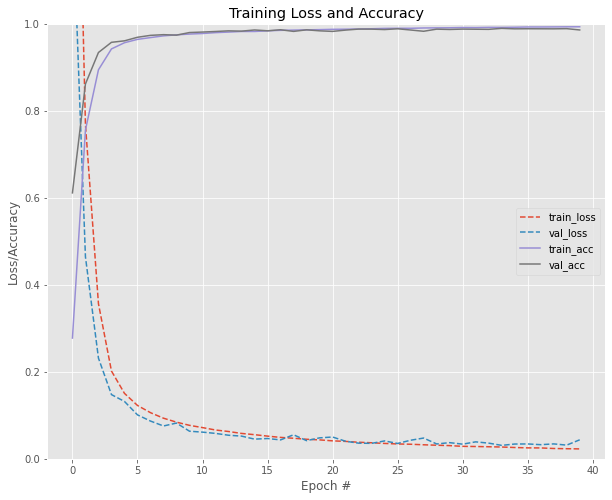

In [24]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 40), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 40), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 40), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 40), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.set_ylim([0, 1])
ax.legend()
plt.show()

In [29]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.006941378553065374 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0004261391137970643 kWh
[INFO] Energy consumed for all GPU: 0.002704520255187552 kWh
[INFO] Energy consumed for all CPU: 0.0038107191840807604 kWh
[INFO] CO2 emission 0.0022073583798747887(in Kg)


In [25]:
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=32)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       1.00      0.98      0.99       958
           7       0.97      1.00      0.98      1028
           8       1.00      0.97      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



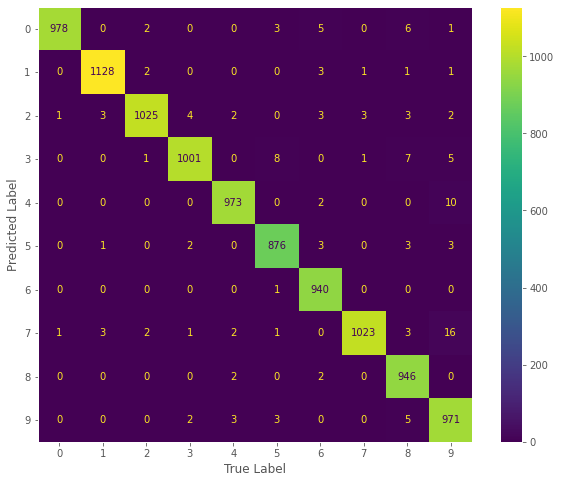

In [27]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,8))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [28]:
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

23-10-2022 21:59:49 Uploading figures


In [30]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

23-10-2022 22:00:16 Validation Evaluation metrics
23-10-2022 22:00:16 Validation Accuracy: 0.9861
23-10-2022 22:00:16 Validation Precision: 0.9862018652354422
23-10-2022 22:00:16 Validation Recall: 0.9861
23-10-2022 22:00:16 Validation F1: 0.9860845099384024


In [33]:
run.finish()

accuracy,▁▆▇█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇███████████████████████████████████
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc,0.9861
CO2_Emissions,0.00221
Count_Params,32718
Energy_CPU,0.00381
Energy_Consumed,0.00694
Energy_GPU,0.0027
